In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

ETA_Q = 5
ETA_R = 5
EPS = 1e-8
STEP = 0.2

# The power of contrastive examples

We compare RL, contrastive examples and demonstrations.

## Environment definition

The environment looks like this:

```
 ---- ---- ---- ---- ---- 
|  1 |  2 |  3 |  4 |  5 |
 ---- ---- ---- ---- ----
|  6 |    |  7 |    |  8 |
 ----      ----      ----
|  9 |    | 10 |    | 11 |
 ----      ----      ----
| 12 |              | 13 |
 ----                ----
| 14 |              | 15 |
 ----                ----  
```

In [2]:
S = list(map(lambda x : str(x), range(1, 16)))

print('States:', S)

States: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']


In [3]:
A = ('Up', 'Down', 'Left', 'Right', 'No-Op')

print('Actions:', A)

Actions: ('Up', 'Down', 'Left', 'Right', 'No-Op')


In [4]:
#               1   2   3   4   5   6   7   8   9   10  11  12  13  14  15           
Pu = np.array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 1
               [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 2
               [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 3
               [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 4
               [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 5
               [.8, 0., 0., 0., 0., .2, 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 6
               [0., 0., .8, 0., 0., 0., .2, 0., 0., 0., 0., 0., 0., 0., 0.],  # 7
               [0., 0., 0., 0., .8, 0., 0., .2, 0., 0., 0., 0., 0., 0., 0.],  # 8
               [0., 0., 0., 0., 0., .8, 0., 0., .2, 0., 0., 0., 0., 0., 0.],  # 9
               [0., 0., 0., 0., 0., 0., .8, 0., 0., .2, 0., 0., 0., 0., 0.],  # 10
               [0., 0., 0., 0., 0., 0., 0., .8, 0., 0., .2, 0., 0., 0., 0.],  # 11
               [0., 0., 0., 0., 0., 0., 0., 0., .8, 0., 0., .2, 0., 0., 0.],  # 12
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., .8, 0., .2, 0., 0.],  # 13
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., .8, 0., .2, 0.],  # 14
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., .8, 0., .2]]) # 15

#               1   2   3   4   5   6   7   8   9   10  11  12  13  14  15           
Pd = np.array([[.2, 0., 0., 0., 0., .8, 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 1
               [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 2
               [0., 0., .2, 0., 0., 0., .8, 0., 0., 0., 0., 0., 0., 0., 0.],  # 3
               [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 4
               [0., 0., 0., 0., .2, 0., 0., .8, 0., 0., 0., 0., 0., 0., 0.],  # 5
               [0., 0., 0., 0., 0., .2, 0., 0., .8, 0., 0., 0., 0., 0., 0.],  # 6
               [0., 0., 0., 0., 0., 0., .2, 0., 0., .8, 0., 0., 0., 0., 0.],  # 7
               [0., 0., 0., 0., 0., 0., 0., .2, 0., 0., .8, 0., 0., 0., 0.],  # 8
               [0., 0., 0., 0., 0., 0., 0., 0., .2, 0., 0., .8, 0., 0., 0.],  # 9
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],  # 10
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., .2, 0., .8, 0., 0.],  # 11
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., .2, 0., .8, 0.],  # 12
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., .2, 0., .8],  # 13
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],  # 14
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]) # 15


#               1   2   3   4   5   6   7   8   9   10  11  12  13  14  15           
Pl = np.array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 1
               [.8, .2, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 2
               [0., .8, .2, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 3
               [0., 0., .8, .2, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 4
               [0., 0., 0., .8, .2, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 5
               [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 6
               [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],  # 7
               [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],  # 8
               [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],  # 9
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],  # 10
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],  # 11
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],  # 12
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],  # 13
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],  # 14
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]) # 15



#               1   2   3   4   5   6   7   8   9   10  11  12  13  14  15           
Pr = np.array([[.2, .8, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 1
               [0., .2, .8, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 2
               [0., 0., .2, .8, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 3
               [0., 0., 0., .2, .8, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 4
               [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 5
               [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],  # 6
               [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],  # 7
               [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],  # 8
               [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],  # 9
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],  # 10
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],  # 11
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],  # 12
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],  # 13
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],  # 14
               [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]) # 15


Pn = np.eye(len(S))

P = [Pu, Pd, Pl, Pr, Pn]

print('Transition probabilities ok?')

for aidx in range(len(A)):
    print('\t- Action %s:' % A[aidx], np.all(np.isclose(P[aidx].sum(axis=1), 1.)))
    
gamma = 0.99

Transition probabilities ok?
	- Action Up: True
	- Action Down: True
	- Action Left: True
	- Action Right: True
	- Action No-Op: True


In [5]:
# Rewards are a convex combination of 7 features/rewards
CELL_GOAL = np.zeros((len(S), len(A)))
CELL_GOAL[14, :] = 1

CELL_10 = np.zeros((len(S), len(A)))
CELL_10[9, :] = 1

CELL_14 = np.zeros((len(S), len(A)))
CELL_14[13, :] = 1


RFEAT = (CELL_GOAL, CELL_10, CELL_14)

## MDP solver

The next function is used to compute the optimal $Q$-function for MDPs. For computational efficiency, we pre-compute the optimal $Q$-function for all MDPs.

In [6]:
def vi(M):
    ''' 
    Compute optimal Q-function for MDP M.

    :param M: 5-tuple corresponding to MDP description: (S, A, P, R, gamma)
    :return: np.array with shape (|S|, |A|), corresponding to Q* for M.
    '''

    S = M[0]
    A = M[1]
    P = M[2]
    R = M[3]
    gamma = M[4]
    
    Q = np.zeros((len(S), len(A)))
    quit = False
    niter = 0
    
    while not quit:
        Qnew = np.zeros((len(S), len(A)))
        V = np.max(Q, axis=1, keepdims=True)
        for a in range(len(A)):
            Qnew[:, a, None] = R[:, a, None] + gamma * P[a].dot(V)
            
        if np.linalg.norm(Q - Qnew) < EPS:
            quit = True
            
        Q = Qnew
        niter += 1
        
    # print('Finished after %i iterations.' % niter)
    return Q

# --

def greedy(Q):
    ''' 
    Compute greedy policy with respect to Q.
    
    :param Q: np.array with shape (|S|, |A|).
    :return: np.array with shape (|S|, |A|), corresponding to pi_g(Q).
    '''
    
    pol = (Q == np.max(Q, axis=1, keepdims=True)).astype(int)
    pol = pol / np.sum(pol, axis=1, keepdims=True)

    return pol

# --

def boltzmann(Q):
    ''' 
    Computes the Boltzmann policy with respect to Q.

    :param Q: np.array with shape (|S|, |A|).
    :return: np.array with shape (|S|, |A|) corresponding to pi_B(Q).
    '''
    
    Q = ETA_Q * (Q - np.max(Q, axis=1, keepdims=True))

    pol = np.round(np.exp(Q), 3)
    pol = pol / np.sum(pol, axis=1, keepdims=True)
    
    return pol

# --

In [7]:
w = np.random.randn(4)
r = np.sum([RFEAT[m] * w[m] for m in range(len(RFEAT))], axis=0)
M = (S, A, P, r, gamma)
Q = vi(M)
pol = boltzmann(Q)

## RL updater

We perform maximum likelihood estimation using SGD, where 

$$r_t\sim\mathrm{Normal}(w^\top\phi(s_t,a_t);\eta)$$

In [8]:
# Weight update
def rl_update(wold, s, a, r):
    ''' 
    Updates the weights wold given the triplet (s, a, r) and the weight w. 
    The update is a Stochastic Gradient Descent (SGD) update on the negative log likelihood, assuming the
    reward is disturbed by 0-mean Gaussian noise.
    
    :param wold: np.array with shape (nfeat,)
    :param s: int (state index)
    :param a: int (action index)
    :param r: float (reward)
    :return: np.array with shape (nfeat,)
    '''
    
    feat = np.array([RFEAT[m][s, a] for m in range(len(RFEAT))])
    
    grad = feat * (feat.dot(wold) - r)    
    wnew = wold - STEP * grad

    return wnew

## Demonstration updater

We perform maximum likelihood estimation using SGD, where 

$$\mathbb{P}[a_t\mid s_t]=\frac{\exp\{\eta Q^*_w(s,a)\}}{\sum_{a'}\exp\{\eta_Q Q^*_w(s,a')\}},$$

where $Q^*_w$ is the optimal $Q$-function for the MDP with reward $w^\top\phi$.

In [9]:
def policy_feat(pol, feat):
    '''
    Compute the policy-weighted feature matrix. 
    "pol" can be a single action index or a full 
    |S| x |A| policy matrix.
    
    :param pol: int (action index) or np.array with shape (|S|, |A|) (policy)
    :param feat: tuple (each element is a (|S|, |A|)-shaped np.array)
    :return: np.array with shape (|S|, |nfeat|)
    '''
    
    if isinstance(pol, int):
        return np.hstack([feat[m][:, pol, None] for m in range(len(feat))])
    
    else:
        return np.hstack([np.sum(feat[m] * pol, axis=1, keepdims=True) for m in range(len(feat))])
    
# --

def policy_trans(pol, P):
    '''
    Compute the policy-weighted transition probabilities.
    
    :param pol: np.array with shape (|S|, |A|) (policy)
    :param P: tuple (each element is a (|S|, |S|)-shaped np.array)
    :return: np.array with shape (|S|, |S|)
    '''
    
    return np.sum([np.diag(pol[:, a]).dot(P[a]) for a in range(len(A))], axis=0)

# --

def policy_rew(pol, r):
    '''
    Compute the policy-weighted reward.
    
    :param pol: np.array with shape (|S|, |A|) (policy)
    :param r: np.array with shape (|S|, |A|) (reward)
    :return: np.array with shape (|S|,)
    '''
    
    return np.sum(pol * r, axis=1)

# --

def discounted_freq(pol, P):
    '''
    Compute the discounted visitation frequencies given a policy pol.
    
    :param pol: np.array with shape (|S|, |A|) (policy)
    :param P: tuple (each element is a (|S|, |S|)-shaped np.array)
    :return: np.array with shape (|S|, |S|)
    '''
    
    Ppol = policy_trans(pol, P)
    return (1 - gamma) * np.linalg.inv(np.eye(len(S)) - gamma * Ppol)

# --
    
# Weight update
def demo_update(wold, s, a, pol=None):
    ''' 
    Updates the weights wold given the pair (s, a) and the weight wold. 
    The update is a SGD update on the negative log likelihood, assuming the
    actions are selected from a Boltzmann distribution (pol, which can be
    precomputed).
    
    :param wold: np.array with shape (|nfeat|,)
    :param s: int (state index)
    :param a: int (action index)
    :param pol: np.array with shape (|S|, |A|) (policy)
    :return: np.array with shape (nfeat,)
    '''

    if pol is None:
        rhat = np.sum([RFEAT[m] * w[m] for m in range(len(RFEAT))], axis=0)
        M = (S, A, P, rhat, gamma)
        Q = vi(M)
        pol = boltzmann(Q)

    feat = policy_feat(greedy(Q), RFEAT) # (nS, nF)
    disc = discounted_freq(greedy(Q), P) # (nS, nS)
    
    grad = np.zeros(wold.shape)

    for a_idx in range(len(A)):
              #              (nS, nF)                     (nS, nS) (nS, nS) (nS, nF)
        grad += ETA_Q * (policy_feat(a_idx, RFEAT) + gamma * P[a_idx].dot(disc).dot(feat))[s, :] * (pol[s, a_idx] - int(a == a_idx))
        
    # Gradients are too small, so we push the step-size up
    
    wnew = wold - 2 * STEP * grad
        
    return wnew

In [10]:
print('policy_feat(.):', policy_feat(pol, RFEAT).shape)
print('policy_feat(.):', policy_feat(0, RFEAT).shape)
print('policy_trans(.):', policy_trans(pol, P).shape)
print('policy_rew(.):', policy_rew(pol, r).shape)
print('discounted_freq(.):', discounted_freq(pol, P).shape)

policy_feat(.): (15, 3)
policy_feat(.): (15, 3)
policy_trans(.): (15, 15)
policy_rew(.): (15,)
discounted_freq(.): (15, 15)


## Contrastive examples updater

We consider the following contrastive examples:

- In state $s$ action $a$ is better than action $a'$ because it will eventually lead you through state $s'$ and that is good.
- In state $s$ action $a$ is worse than action $a'$ because it will eventually lead you through state $s'$ and that is bad.

We consider that, given the target reward $r$,

- A state $s$ is good if $r^*(s)>0$ for the optimal policy $\pi^*_r$ given that reward.
- A state $s$ is bad if $r^*(s)<0$ for the optimal policy $\pi^*_r$ given that reward.
- An action $a$ is _better_ than an action $a'$ in state $s$ and leading to state $s'$ if the following two conditions are cumulatively met:

 - $Q^*(s,a)>Q^*(s,a')$ ($a$ is better than $a'$)
    * The transition probabilities by first taking action $a$ and then following $\pi^*$ lead to larger transition probability from $s$ to $s'$ than those same probabilities taking action $a'$.
    
- An action $a$ is _worse_ than an action $a'$ in state $s$ and leading to state $s'$ if the following two conditions are cumulatively met:

 - $Q^*(s,a)<Q^*(s,a')$ ($a$ is worse than $a'$)
    * The transition probabilities by taking action $a$ in $s$ and following $\pi^*$ elsewhere lead to larger transition probability from $s$ to $s'$ than those same probabilities taking action $a'$.

In [11]:
def sigmoid(z, eta):
    ''' 
    Compute sigmoid function.
    
    :param z: float
    :param eta: float
    :return: float
    '''
    
    return 1 / (1 + np.exp(-eta * z))

# --

We perform maximum likelihood estimation using SGD, where 

$$\mathbb{P}[(s,a,a',s',k)\mid w]=\sigma(kr_w(s'))\sigma(k(Q(s,a)-Q(s,a')))\mathbf{P}_{a}^\infty(s'\mid s)$$

(see precise definition in the paper).

In [12]:
# Weight update
def explain_update(wold, s0, s1, a0, a1, k, Q=None):
    '''
    Updates the weights wold given the tuple (s0, s1, a0, a1, k) 
    and the weight wold. The update is a SGD update on the negative 
    log likelihood, assuming the distribution above.

    '''
    
    # Compute policy
    r = np.sum([RFEAT[m] * wold[m] for m in range(len(RFEAT))], axis=0)

    if Q is None:
        M = (S, A, P, r, gamma)
        Q = vi(M)
        
    pol = boltzmann(Q)

    paux = pol.copy()
    paux[s0] = np.zeros(len(A))
    paux[s0, a0] = 1.0
        
    # Component 1 - reward
    fpol = policy_feat(greedy(Q), RFEAT)      # (nS, nF)
    rpol = policy_rew(greedy(Q), r) # (nS,)

    grad_R = ETA_R * k * fpol[s1, :] * (sigmoid(k * rpol[s1], ETA_R) - 1) # (nF,)
    #print('grad_R:')
    #print(grad_R)
    
    # Component 2 - Q-values
    fa0 = policy_feat(a0, RFEAT)   # (nS, nF)
    fa1 = policy_feat(a1, RFEAT)   # (nS, nF)
    freq = discounted_freq(greedy(Q), P) # (nS, nS)

    diff_Q = Q[s0, a0] - Q[s0, a1]       # scalar
    diff_P = P[a0][s0, :] - P[a1][s0, :] # (nS,)
    diff_F = fa0[s0] - fa1[s0]           # (nF,)
    
    grad_Q = ETA_Q * k * (diff_F + gamma * diff_P.dot(freq).dot(fpol)) * (sigmoid(k * diff_Q, ETA_Q) - 1) # (nF,)
    #print('grad_Q:')
    #print(grad_Q)

    # Component 3 - Pam
    Pam = discounted_freq(paux, P) # (nS, nS)
    pf = Pam.dot(fpol)             # (nS, nF)
    
    grad_P = np.zeros(len(RFEAT))
    
    for k in range(len(RFEAT)):
        # for a single k
        grad_aux = np.zeros((len(S), len(S)))

        for a in range(len(A)):
            for ap in range(len(A)):
                fa  = policy_feat(a, RFEAT)  # (nS, nF)
                fap = policy_feat(ap, RFEAT) # (nS, nF)
                    #  (nS,)            (nS, nS) (nS, nS) (nS,)
                dT  = fap[:, k] + gamma * P[ap].dot(freq).dot(fpol[:, k]) # (nS,)
                tmp = ETA_Q * np.diag(paux[:, a] * dT * (pol[:, ap] - int(a == ap))).dot(P[a]) # (nS, nS)

                grad_aux += tmp

        dPk = Pam.dot(grad_aux).dot(Pam)      # (nS, nS)
        if np.isclose(Pam[s0, s1], 0) and not np.isclose(dPk[s0, s1], 0):
            print('Whoa! Zero!')
            print('dPk:', dPk[s0, s1])

        elif np.isclose(Pam[s0, s1], 0):
            grad_P[k] = 0.                        # scalar

        else:
            grad_P[k] = dPk[s0, s1] / Pam[s0, s1] # scalar
        
    #print('grad_P:')
    #print(grad_P)
    
    grad = grad_R + grad_Q + grad_P
    
    wnew = wold - STEP * grad
    
    return wnew

In [13]:
freq = discounted_freq(pol, P)
fpol = policy_feat(pol, RFEAT)
print('P[a][s, :]:', P[0][0, :].shape)
print('freq:', freq.shape)
print('fpol:', fpol.shape)
print('P[a][s, :].dot(freq):', P[0][0, :].dot(freq).shape)
print('P[a][s, :].dot(freq).dot(fpol):', P[0][0, :].dot(freq).dot(fpol).shape)

P[a][s, :]: (15,)
freq: (15, 15)
fpol: (15, 3)
P[a][s, :].dot(freq): (15,)
P[a][s, :].dot(freq).dot(fpol): (3,)


## Experiments

We now generate a random reward, and compare the performance of an RL updater, a demo updater and an contrastive examples updater in randomly selected sample rewards, demos and contrastive examples.

We start by defining the samplers.

In [14]:
def sample_reward(M):
    ''' Samples a reward for MDP M. '''

    S = M[0]
    A = M[1]
    R = M[3]
    
    # Sample a random state
    sample_s = np.random.choice(len(S))
    
    # Sample a random action
    sample_a = np.random.choice(len(A))
    
    # Sample a noisy reward
    sample_r = R[sample_s, sample_a] + np.random.randn() / ETA_R
    
    return (sample_s, sample_a, sample_r)

# -- 

def voice_reward(M, s, a, r):
    ''' Converts a reward sample into a natural language string. '''
    
    return 'The reward in state %s when performing action %s is %.2f.' % (M[0][s], M[1][a], r)

In [15]:
voice_reward(M, *sample_reward(M))

'The reward in state 1 when performing action Down is 0.18.'

In [16]:
def sample_demo(M):
    ''' Samples a demonstration for MDP M. '''

    S = M[0]
    A = M[1]
    
    # Sample a random state
    sample_s = np.random.choice(len(S))

    # Sample a noisy action
    Q = vi(M)
    pol = boltzmann(Q)[sample_s, :]
    sample_a = np.random.choice(len(A), p=pol)
    
    return (sample_s, sample_a)

# --

def voice_demo(M, s, a):
    ''' Converts a demonstration sample into a natural language string. '''

    return 'In state %s you should perform action %s.' % (M[0][s], M[1][a])

In [17]:
Q = vi(M)
pol = boltzmann(Q)
print(pol.sum(axis=1))
voice_demo(M, *sample_demo(M))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


'In state 6 you should perform action No-Op.'

In [18]:
def sample_explain(M, echo=False):
    ''' Samples an contrastive examples for MDP M. '''

    S = M[0]
    A = M[1]
    P = M[2]
    R = M[3]
    gamma = M[4]
    
    Q = vi(M)
    pol = boltzmann(Q)
    rpol = policy_rew(pol, R)

    sample_complete = False
    
    while not sample_complete:
        
        # This ensures that the search for next state doesn't go on forever
        stop_sample = False
        
        # Sample a random initial state
        sample_s0 = np.random.choice(len(S))
        
        if echo:
            print('Sampled state %s' % S[sample_s0])

        # Sample a random initial action
        sample_a0 = np.random.choice(len(A))
        
        if echo:
            print('Sampled action %s' % A[sample_a0])

        paux = pol.copy()
        paux[sample_s0] = np.zeros(len(A))
        paux[sample_s0, sample_a0] = 1.0
        
        Pam = discounted_freq(paux, P)

        # Sample a random second action (different from the first)
        quit = False
        while not quit:
            sample_a1 = np.random.choice(len(A))
            quit = sample_a1 != sample_a0

        if echo:
            print('Sampled another action: %s' % A[sample_a1])

        # Sample a random via state with non-zero reward (to fit the "good" or "bad" description)

        quit = False
        while not quit:
            paux = np.maximum(rpol * (Q[sample_s0, sample_a0] - Q[sample_s0, sample_a1]) * Pam[sample_s0, :], 0)

            # Ensure that there is a next state to sample
            if np.isclose(np.sum(paux), 0):
                if echo:
                    print('Zero support distribution. Restarting sampling.')
                stop_sample = True
                quit = True
            else:
                paux = paux / paux.sum()
                if np.isclose(paux[sample_s0], 1.):
                    if echo:
                        print('Departing from sink. Restarting sampling.')
                    stop_sample = True
                    quit = True
                else:
                    if echo:
                        print(np.round(paux, 3))
                    sample_s1 = np.random.choice(len(S), p=paux)
                    quit = (sample_s1 != sample_s0)

        if not stop_sample:
            if echo:
                print('Sampled another state: %s' % S[sample_s1])

            # Check which one is better
            if Q[sample_s0, sample_a0] > Q[sample_s0, sample_a1]:
                k = 1
            else:
                k = -1
                
            sample_complete = True
            
    if echo:
        print('Q(%s, %s) =' % (S[sample_s0], A[sample_a0]), Q[sample_s0, sample_a0])
        print('Q(%s, %s) =' % (S[sample_s0], A[sample_a1]), Q[sample_s0, sample_a1])
        print('reward(%s) =' % S[sample_s1], np.sum(R * pol, axis=1)[sample_s1])
        print('P_m[%s](%s, %s) =' % (A[sample_a0], S[sample_s0], S[sample_s1]), Pam[sample_s0, sample_s1])
        
    return (sample_s0, sample_s1, sample_a0, sample_a1, k)

# --
        
def voice_explain(M, s0, s1, a0, a1, k):
    ''' Converts an exmplanation sample into a natural language string. '''

    REL1 = ('better', 'worse')
    REL2 = ('good', 'bad')
    
    k = 1 - (k + 1) // 2
    
    return 'In state %s, action %s is %s than %s because it may eventually lead you through state %s and that is %s.' % (M[0][s0], M[1][a0], REL1[k], M[1][a1], M[0][s1], REL2[k])


In [19]:
voice_explain(M, *sample_explain(M, echo=True))

Sampled state 13
Sampled action No-Op
Sampled another action: Right
Zero support distribution. Restarting sampling.
Sampled state 13
Sampled action Left
Sampled another action: Up
Zero support distribution. Restarting sampling.
Sampled state 14
Sampled action Up
Sampled another action: Down
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Sampled another state: 10
Q(14, Up) = 16.614283573623823
Q(14, Down) = 15.92041665797559
reward(10) = 0.19096048511266883
P_m[Up](14, 10) = 0.6290687153266841


'In state 14, action Up is better than Down because it may eventually lead you through state 10 and that is good.'

We now run a comparative study. Every 10 steps, for each of the three approaches, we:

* Estimate the reward;
* Compute the associated "optimal" policy;
* Evaluate that policy in the correct MDP.

The next function is used in the last step.

In [20]:
def evaluate_reward(M, w):
    ''' Computes the policy from weights w in the MDP M.'''

    S = M[0]
    A = M[1]
    P = M[2]
    R = M[3]
    gamma = M[4]
    
    Raux = np.sum([w[i] * RFEAT[i] for i in range(len(RFEAT))], axis=0)
    
    Maux = (S, A, P, Raux, gamma)
    pol  = greedy(vi(Maux))
    
    Ppol = policy_trans(pol, P)
    Rpol = policy_rew(pol, R)
    
    Vaux = np.linalg.inv(np.eye(len(S)) - gamma * Ppol).dot(Rpol)

    # Compute average value
    return Vaux.sum() / len(S)

We can now run our comparative study.

In [21]:
# Simulation constants
NRUNS = 30
NSTEPS = 15

# For performance statistics
perf_rl   = np.zeros((NRUNS, NSTEPS))
perf_demo = np.zeros((NRUNS, NSTEPS))
perf_expl = np.zeros((NRUNS, NSTEPS))
perf_ref  = np.zeros((NRUNS, NSTEPS))

# For reproducibility
np.random.seed(40)

samples_expl = []
samples_demos = []
samples_rl = []

# Run sims
for run in trange(NRUNS):
    
    # Initialize a random reward
    wopt = np.random.randn(len(RFEAT))
    ropt = np.sum([wopt[i] * RFEAT[i] for i in range(len(RFEAT))], axis=0)
    
    #print('Reward:')
    #print(np.round(ropt,2))
                  
    # This is the "target" MDP
    Mopt = (S, A, P, ropt, gamma)
    
    # Optimal policy
    popt = greedy(vi(Mopt))
    
    #print('Optimal policy:')
    #print(np.round(popt, 2))
    
    # Weights for 3 approaches
    w_rl   = np.zeros(len(RFEAT))
    w_demo = np.zeros(len(RFEAT))
    w_expl = np.zeros(len(RFEAT))
    
    # Run test
    for t in range(NSTEPS):
        #print('\n[Step %i]' % (t + 1))

        # Sample a reward and update
        #print('Sampling reward... ')
        (s, a, r) = sample_reward(Mopt)
        #print('Updating weights for reward... ')
        w_rl = rl_update(w_rl, s, a, r)
        #print('Weights:')
        #print(w_rl)

        
        # Evaluate
        #print('Evaluating reward...')
        perf_rl[run, t] = evaluate_reward(Mopt, w_rl)
        samples_rl.append(perf_rl[run, t])
        #print(voice_reward(Mopt, s, a, r))
        
        # Sample a demo and update
        #print('\nSampling demo... ')
        (s, a) = sample_demo(Mopt)
        #print('Updating weights for demo... ')
        w_demo = demo_update(w_demo, s, a)
        #print('Weights:')
        #print(w_demo)

        
        # Evaluate
        #print('Evaluating reward...')
        perf_demo[run, t] = evaluate_reward(Mopt, w_demo)
        samples_demos.append(perf_demo[run, t])
        #print(voice_demo(Mopt, s, a))
        
        # Sample an contrastive examples and update
        #print('\nSampling contrastive examples... ')
        (s0, s1, a0, a1, k) = sample_explain(Mopt)
        
        #print('Updating weights for contrastive examples... ')
        w_expl = explain_update(w_expl, s0, s1, a0, a1, k)
        #print('Weights:')
        #print(w_expl)
        
        # Evaluate
        #print('Evaluating reward...')
        perf_expl[run, t] = evaluate_reward(Mopt, w_expl)
        samples_expl.append(perf_expl[run, t])
        #print(voice_explain(M, s0, s1, a0, a1, k))
        
        perf_ref[run, t] = evaluate_reward(Mopt, wopt)
        
        #print('Done. Step complete.')
        
# Compute statistics
rl_mean = np.mean(perf_rl, axis=0)
rl_std = np.std(perf_rl, axis=0) / np.sqrt(NRUNS)



demo_mean = np.mean(perf_demo, axis=0)
demo_std = np.std(perf_demo, axis=0) / np.sqrt(NRUNS)

expl_mean = np.mean(perf_expl, axis=0)
expl_std = np.std(perf_expl, axis=0) / np.sqrt(NRUNS)

ref_mean = np.mean(perf_ref, axis=0)

  0%|          | 0/30 [00:00<?, ?it/s]

In [22]:
ref_mean

array([61.05452237, 61.05452237, 61.05452237, 61.05452237, 61.05452237,
       61.05452237, 61.05452237, 61.05452237, 61.05452237, 61.05452237,
       61.05452237, 61.05452237, 61.05452237, 61.05452237, 61.05452237])

In [23]:
rl_min = np.min(rl_mean, axis=0)
rl_range = np.max(rl_mean, axis=0) - np.min(rl_mean, axis=0)
rl_norm = (rl_mean - rl_min)/rl_range
rl_normstd = np.std(rl_norm, axis=0) / np.sqrt(NRUNS)

demo_min = np.min(demo_mean, axis=0)
demo_range = np.max(demo_mean, axis=0) - np.min(demo_mean, axis=0)
demo_norm = (demo_mean - demo_min)/demo_range
demo_normstd = np.std(demo_norm, axis=0) / np.sqrt(NRUNS)

expl_min = np.min(expl_mean, axis=0)
expl_range = np.max(expl_mean, axis=0) - np.min(expl_mean, axis=0)
expl_norm = (expl_mean - expl_min)/expl_range
expl_normstd = np.std(expl_norm, axis=0) / np.sqrt(NRUNS)


ref_min = np.min(ref_mean)
ref_range = np.max(ref_mean) - np.min(ref_mean)
ref_norm = (ref_mean - ref_min)/ref_range

<ipython-input-23-a6cb8b7f165e>:19: RuntimeWarning: invalid value encountered in true_divide
  ref_norm = (ref_mean - ref_min)/ref_range


In [24]:
ref_min

61.05452236561643

In [25]:
rl_normstd

0.05525263294021012

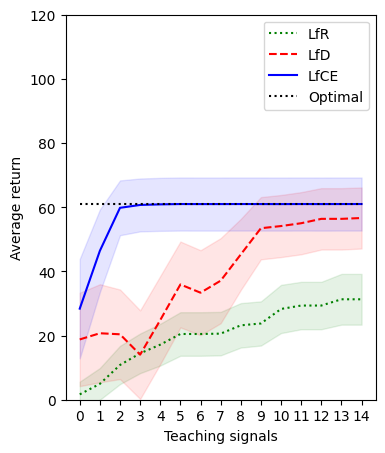

In [26]:
# Plot
plt.figure(figsize=(4, 5))
plt.fill_between(range(NSTEPS), rl_mean + rl_std, rl_mean - rl_std, color='g', alpha=0.1)
plt.fill_between(range(NSTEPS), demo_mean + demo_std, demo_mean - demo_std, color='r', alpha=0.1)
plt.fill_between(range(NSTEPS), expl_mean + expl_std, expl_mean - expl_std, color='b', alpha=0.1)
plt.plot(range(NSTEPS), rl_mean, 'g:', label='LfR')
plt.plot(range(NSTEPS), demo_mean, 'r--', label='LfD')
plt.plot(range(NSTEPS), expl_mean, 'b-', label='LfCE')
plt.plot(range(NSTEPS), ref_mean, 'k:', label='Optimal')
#plt.xlabel('N. samples')
#plt.ylabel(r'$||V_\pi||_2$')
plt.xlabel('Teaching signals')
plt.ylabel('Average return')
plt.ylim(0, 120)
plt.xticks(range(0, 15))
plt.legend(loc='best')
plt.show()

In [27]:
wopt

array([-0.80559438, -1.25024501,  0.78905044])

In [28]:
print('Optimal:')
print(wopt)
print('Contrastive Examples:')
print(w_expl)
print('Demos:')
print(w_demo)
print('RL:')
print(w_rl)

Optimal:
[-0.80559438 -1.25024501  0.78905044]
Contrastive Examples:
[-0.00285149 -0.00392236  0.89322664]
Demos:
[-0.00241106 -0.25402383  0.09612059]
RL:
[-0.18596769 -0.22368096  0.26503212]


In [29]:
wopt = [-0.80559438, -1.25024501,  0.78905044]
w_expl = [-0.00285149, -0.00392236,  0.89322664]
w_demos = [ 1.09113395e-17, -4.06255996e-01,  9.26802108e-02]
w_rl = [-0.18596769, -0.22368096,  0.26503212]

In [30]:
wopt_mean = np.mean(wopt)

In [31]:
wexpl_mean = np.mean(w_expl)

In [32]:
wdemos_mean = np.mean(w_demos)

In [33]:
wrl_mean = np.mean(w_rl)

In [34]:
print(wopt_mean, wexpl_mean, wdemos_mean, wrl_mean)

-0.42226298333333334 0.29548426333333333 -0.10452526173333333 -0.04820551000000001


In [35]:
expl_opt = wopt[0] - w_demos[0]
expl_opt

-0.80559438

In [36]:
import scipy.stats
from scipy.stats import f_oneway
from scipy.stats import normaltest, ttest_rel, shapiro, mannwhitneyu, wilcoxon, ranksums, ttest_ind, kruskal, sem

In [37]:
ttest_rel(perf_rl, perf_demo)

TtestResult(statistic=array([-1.27793327, -1.13314536, -0.78074495,  0.02751001, -0.54098063,
       -1.2853725 , -0.95475253, -1.37754281, -2.28126511, -3.38298801,
       -3.05575287, -3.03228008, -3.21306073, -2.97975579, -3.02189091]), pvalue=array([0.21140793, 0.26643481, 0.44127942, 0.9782414 , 0.59265256,
       0.20883277, 0.34759425, 0.1788837 , 0.03006045, 0.0020702 ,
       0.00478267, 0.00507279, 0.00320948, 0.00578374, 0.00520647]), df=array([29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29]))

In [38]:
print('normal test, reward: ', normaltest(rl_mean), 'demostration', normaltest(demo_mean), 'explanation', normaltest(expl_mean))

normal test, reward:  NormaltestResult(statistic=1.6712937179221419, pvalue=0.4335939165894206) demostration NormaltestResult(statistic=6.079618656299149, pvalue=0.047844011130685135) explanation NormaltestResult(statistic=29.66295672849111, pvalue=3.620518641517437e-07)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [39]:
mannwhitneyu(rl_mean,demo_mean)

MannwhitneyuResult(statistic=44.0, pvalue=0.004776024960228471)

In [40]:
mannwhitneyu(wopt,w_expl)

MannwhitneyuResult(statistic=2.0, pvalue=0.4)

In [41]:
mannwhitneyu(w_rl,w_expl)

MannwhitneyuResult(statistic=2.0, pvalue=0.4)

In [42]:
mannwhitneyu(w_demo,w_expl)

MannwhitneyuResult(statistic=4.0, pvalue=1.0)

In [43]:
mannwhitneyu(rl_mean,expl_mean)

MannwhitneyuResult(statistic=4.0, pvalue=7.3214532961732006e-06)

In [44]:
mannwhitneyu(demo_mean,expl_mean)

MannwhitneyuResult(statistic=16.0, pvalue=6.748052131560162e-05)

In [45]:
ttest_rel(rl_mean,demo_mean)

TtestResult(statistic=-8.347806126715604, pvalue=8.315740273608295e-07, df=14)

In [46]:
ttest_rel(rl_mean,expl_mean)

TtestResult(statistic=-21.702958031833415, pvalue=3.542197589593881e-12, df=14)

In [47]:
ttest_rel(expl_mean,demo_mean)

TtestResult(statistic=5.151712539350739, pvalue=0.00014703165267441895, df=14)